In [1]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random
import pickle
import logging

In [2]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [ ]:
def add_guassian_noise_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        channels_to_corrupt = int(64 / 10 * severity_index)
        dataset[0][episode] = add_gaussian_noise(dataset[0][episode], 2 * severity_index, channels_to_corrupt, low, high)

    return dataset

In [ ]:
def add_zero_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset
    
    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
            # Can range from 5-50%
        channels_to_corrupt = int(64 / 20 * severity_index)
            # Zeroes the entire signal
        dataset[0][episode] = zero_signal(dataset[0][episode], channels_to_corrupt, low, high, 100)

    return dataset

In [ ]:
# Plot the first 5 channels of the original signal, localized noise on 0-250ms, and localized noise on 250-500ms

train, val, test = create_dataset('./src/pickle_df', 1)

train_copy = copy.deepcopy(train)
left_gaussian_noise = add_guassian_noise_to_dataset(train_copy, 10, low = 0, high = 127)

train_copy = copy.deepcopy(train)
right_gaussian_noise = add_guassian_noise_to_dataset(train_copy, 10, low = 128, high = 255)

train_copy = copy.deepcopy(train)
left_zeroing_noise = add_zero_to_dataset(train_copy, 10, low = 0, high = 127)

train_copy = copy.deepcopy(train)
right_zeroing_noise = add_zero_to_dataset(train_copy, 10, low = 128, high = 255)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)

figure, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0][0].plot(t, train[0][0][0], label='1')
axes[0][0].plot(t, train[0][0][1], label='2')
axes[0][0].plot(t, train[0][0][2], label="3")
axes[0][0].plot(t, train[0][0][3], label="4")
axes[0][0].plot(t, train[0][0][4], label="5")
axes[0][0].set_xlabel("Time (ms)")
axes[0][0].set_ylabel("Amplitude")
axes[0][0].set_title("Original")

axes[0][1].plot(t, left_gaussian_noise[0][0][0], label='1')
axes[0][1].plot(t, left_gaussian_noise[0][0][1], label='2')
axes[0][1].plot(t, left_gaussian_noise[0][0][2], label="3")
axes[0][1].plot(t, left_gaussian_noise[0][0][3], label="4")
axes[0][1].plot(t, left_gaussian_noise[0][0][4], label="5")
axes[0][1].set_xlabel("Time (ms)")
axes[0][1].set_ylabel("Amplitude")
axes[0][1].set_title("Gaussian noise on the 0-250ms region")

axes[0][2].plot(t, right_gaussian_noise[0][0][0], label='1')
axes[0][2].plot(t, right_gaussian_noise[0][0][1], label='2')
axes[0][2].plot(t, right_gaussian_noise[0][0][2], label="3")
axes[0][2].plot(t, right_gaussian_noise[0][0][3], label="4")
axes[0][2].plot(t, right_gaussian_noise[0][0][4], label="5")
axes[0][2].set_xlabel("Time (ms)")
axes[0][2].set_ylabel("Amplitude")
axes[0][2].set_title("Gaussian noise on the 250-500 region")

axes[1][0].plot(t, left_zeroing_noise[0][0][0], label='1')
axes[1][0].plot(t, left_zeroing_noise[0][0][1], label='2')
axes[1][0].plot(t, left_zeroing_noise[0][0][2], label="3")
axes[1][0].plot(t, left_zeroing_noise[0][0][3], label="4")
axes[1][0].plot(t, left_zeroing_noise[0][0][4], label="5")
axes[1][0].set_xlabel("Time (ms)")
axes[1][0].set_ylabel("Amplitude")
axes[1][0].set_title("Zeroing noise on the 250-500 region")

axes[1][1].plot(t, right_zeroing_noise[0][0][0], label='1')
axes[1][1].plot(t, right_zeroing_noise[0][0][1], label='2')
axes[1][1].plot(t, right_zeroing_noise[0][0][2], label="3")
axes[1][1].plot(t, right_zeroing_noise[0][0][3], label="4")
axes[1][1].plot(t, right_zeroing_noise[0][0][4], label="5")
axes[1][1].set_xlabel("Time (ms)")
axes[1][1].set_ylabel("Amplitude")
axes[1][1].set_title("Zeroing noise on the 250-500 region")

figure.tight_layout()
figure.suptitle("The effect of strong localized noise on the first 5 channels")
# Title and subtitle overlap, but its only for visualization

In [ ]:
# Currently, I don't check the SHAP values for the highest influence area, but rather take the theoratical location of highest influence, which happens at around 250-500ms

# 0-250ms for low effect
# 250-500ms for high effect

# Tests for medium noise(5) on the low effect region, and medium noise on the high effect region

variances = [[] for _ in range(2)]
accuracies = [[] for _ in range(2)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', 1)

    for i in range(2):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_guassian_noise_to_dataset(train_copy, 10, low = i * 102, high = (i + 1) * 102 - 1)
        val_copy = add_guassian_noise_to_dataset(val_copy, 10, low = i * 102, high = (i + 1) * 102 - 1)
        test_copy = add_guassian_noise_to_dataset(test_copy, 10, low = i * 102, high = (i + 1) * 102 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/localized_variances_gaussian.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/localized_accuracies_gaussian.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
        
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished " + str(j) + "\n\n\n\n\n") 

In [ ]:
# Currently, I don't check the SHAP values for the highest influence area, but rather take the theoratical location of highest influence, which happens at around 250-500ms

# 0-250ms for low effect
# 250-500ms for high effect

# Tests for medium noise(5) on the low effect region, and medium noise on the high effect region

variances = [[] for _ in range(2)]
accuracies = [[] for _ in range(2)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', 1)

    for i in range(2):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_zero_to_dataset(train_copy, 10, low = i * 102, high = (i + 1) * 102 - 1)
        val_copy = add_zero_to_dataset(val_copy, 10, low = i * 102, high = (i + 1) * 102 - 1)
        test_copy = add_zero_to_dataset(test_copy, 10, low = i * 102, high = (i + 1) * 102 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/localized_variances_zeroed.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/localized_accuracies_zeroed.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished " + str(j) + "\n\n\n\n\n") 

[[0.21445968747138977, 0.21481488645076752, 0.20891253650188446, 0.21007485687732697, 0.22001495957374573, 0.21894200146198273], [0.21443545818328857, 0.21843773126602173, 0.2191126048564911, 0.21823644638061523, 0.2188137024641037, 0.2317148596048355]]
[[0.21445968747138977, 0.21481488645076752, 0.20891253650188446, 0.21007485687732697, 0.22001495957374573, 0.21894200146198273], [0.21443545818328857, 0.21843773126602173, 0.2191126048564911, 0.21823644638061523, 0.2188137024641037, 0.2317148596048355]]


Text(0.5, 1.0, 'Effect of zeroing on accuracy')

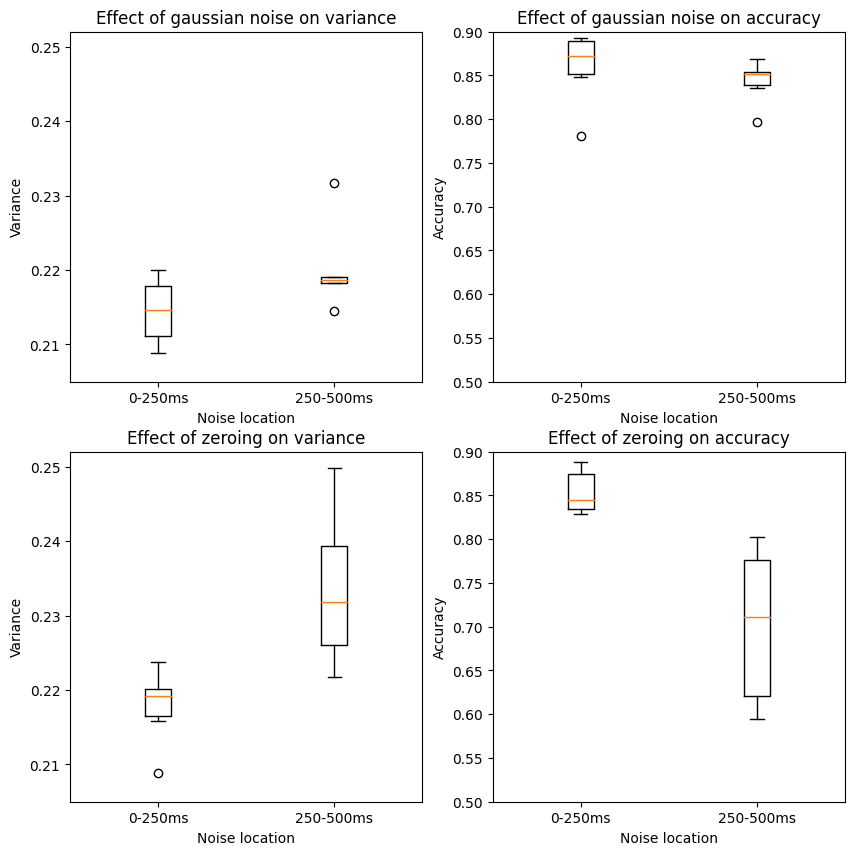

In [28]:
# Load in the .pkl files
with open('results_pickled_backup/localized_accuracies_gaussian.pkl', 'rb') as f:
    accuracies_gaussian = pickle.load(f)

with open('results_pickled_backup/localized_variances_gaussian.pkl', 'rb') as f:
    variances_gaussian = pickle.load(f)

with open('results_pickled_backup/localized_accuracies_zeroed.pkl', 'rb') as f:
    accuracies_zeroed = pickle.load(f)

with open('results_pickled_backup/localized_variances_zeroed.pkl', 'rb') as f:
    variances_zeroed = pickle.load(f)


print(variances_gaussian)

standard_deviation_variances_gaussian = []
standard_deviation_accuracies_gaussian = []
standard_deviation_variances_zeroed = []
standard_deviation_accuracies_zeroed = []


# Create a barplot of the variances and accuracies
print(variances_gaussian)
figure, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0][0].boxplot(variances_gaussian, labels=["0-250ms", "250-500ms"])
axes[0][0].set_ylim(0.205, 0.252)
axes[0][0].set_xlabel("Noise location")
axes[0][0].set_ylabel("Variance")
axes[0][0].set_title("Effect of gaussian noise on variance")
axes[0][1].boxplot(accuracies_gaussian, labels=["0-250ms", "250-500ms"])
axes[0][1].set_ylim(0.5, 0.9)
axes[0][1].set_xlabel("Noise location")
axes[0][1].set_ylabel("Accuracy")
axes[0][1].set_title("Effect of gaussian noise on accuracy")

axes[1][0].boxplot(variances_zeroed, labels=["0-250ms", "250-500ms"])
axes[1][0].set_ylim(0.205, 0.252)
axes[1][0].set_xlabel("Noise location")
axes[1][0].set_ylabel("Variance")
axes[1][0].set_title("Effect of zeroing on variance")
axes[1][1].boxplot(accuracies_zeroed, labels=["0-250ms", "250-500ms"])
axes[1][1].set_ylim(0.5, 0.9)
axes[1][1].set_xlabel("Noise location")
axes[1][1].set_ylabel("Accuracy")
axes[1][1].set_title("Effect of zeroing on accuracy")

# As can be seen, there is practically no difference between the two noise locations
# Variance and accuracy are almost identical